This notebook shows how to:
- Load a trained DiffusionAvatars model
- Prepare the input data for an unseen sequence of the person
- Call the model to get a prediction 

In [2]:
import torch
from matplotlib import pyplot as plt

from diffusion_avatars.data_manager.rendering_data_manager import RenderingName
from diffusion_avatars.dataset.rendering_dataset import RenderingDataset, DatasetSplit
from diffusion_avatars.model_manager.diffusion_avatars_model_manager import DiffusionAvatarsModelFolder

# 1. Load model
Inference requires ~10G of VRAM

In [3]:
model_folder = DiffusionAvatarsModelFolder()
available_runs = model_folder.list_runs()
print("Trained Models:")
for run_name in available_runs:
    print(' -', run_name)

Trained Models:
 - DA-1-ID-18
 - DA-2-ID-37
 - DA-3-ID-55
 - DA-4-ID-124
 - DA-5-ID-145
 - DA-6-ID-210
 - DA-7-ID-251
 - DA-8-ID-264
 - DA-9
 - DA-10


In [4]:
run_name = 'DA-2'

model_manager = model_folder.open_run(run_name)

In [5]:
checkpoint = -1
model = model_manager.load_checkpoint(checkpoint)
model = model.cuda()

Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# 2. Load data

In [6]:
dataset_config = model_manager.load_dataset_config()
dataset_config = dataset_config.eval()  # Disable any cropping
dataset = RenderingDataset(dataset_config, split=DatasetSplit.VALID_HOLD_OUT_SEQ)

In [7]:
sample = dataset[0]
batch = dataset.collate_fn([sample])

In [9]:
latent_shape = model.get_latent_shape()
latent_noise = torch.randn(latent_shape, device=model.device)
batch = model.prepare_batch(batch, latent_noise=latent_noise)

## 2.1. Visualize Input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


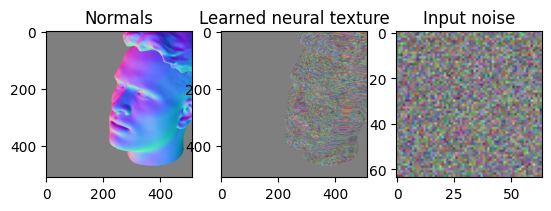

In [11]:
normals_rendering = (sample.renderings[RenderingName.NORMALS].permute(1, 2, 0).numpy() + 1)/2
neural_texture = batch.neural_textured_rendering[0].permute(1, 2, 0).detach().cpu().numpy()[..., :3]
neural_texture = (neural_texture / neural_texture.max() + 1) / 2  # normalize for Visualization
latent_noise_img = batch.latent_noise[0].permute(1, 2, 0).cpu().numpy()[..., :3]
latent_noise_img = (latent_noise_img / latent_noise_img.max() + 1) / 2  # normalize for Visualization

nrows = 1
ncols = 3
plt.subplot(nrows, ncols, 1)
plt.title('Normals')
plt.imshow(normals_rendering)

plt.subplot(nrows, ncols, 2)
plt.title('Learned neural texture')
plt.imshow(neural_texture)

plt.subplot(nrows, ncols, 3)
plt.title('Input noise')
plt.imshow(latent_noise_img)

plt.show()

# 3. Forward

In [12]:
output = model.inference(batch)

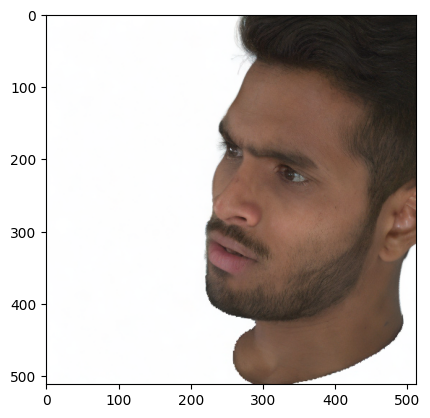

In [13]:
plt.imshow(output[0].prediction)
plt.show()